In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = pd.read_excel('Rohan Sindhoora Demand_Data_2017-2018.xlsx')
data.head(3)

,Unnamed: 0,Monthly demand (units),Unnamed: 2,Demand forecast (units),Unnamed: 4
0,Date,CoughX,InfeX,CoughX - Exp Smoothing,InfeX - Exp Smoothing
1,2017-01-01 00:00:00,132966.97,66497.86,NaN,NaN
2,2017-02-01 00:00:00,114928.62,52188.43,NaN,NaN


In [ ]:
data = data.drop(columns=['Demand forecast (units)', 'Unnamed: 4'])
new_header = data.iloc[0]
data = data[1:]
data.columns = new_header
data.head(3)

,Date,CoughX,InfeX
1,2017-01-01 00:00:00,132966.97,66497.86
2,2017-02-01 00:00:00,114928.62,52188.43
3,2017-03-01 00:00:00,104504.07,68276.89


In [ ]:
data.describe()

,Date,CoughX,InfeX
count,36,24.00,24.00
unique,36,24.00,24.00
top,2017-01-01 00:00:00,132966.97,66497.86
freq,1,1.00,1.00


In [ ]:
data.dtypes

0
Date      object
CoughX    object
InfeX     object
dtype: object

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['CoughX'] = data['CoughX'].astype(float)
data['InfeX'] = data['InfeX'].astype(float)

In [ ]:
data.describe()

,CoughX,InfeX
count,24.000000,24.000000
mean,111592.625000,78413.030000
std,59852.198715,21603.066937
min,17782.770000,52188.430000
25%,69152.600000,61447.787500
50%,98322.840000,75474.825000
75%,143593.442500,87860.715000
max,246135.090000,143253.180000


(array([2., 3., 5., 3., 3., 3., 2., 0., 2., 1.]),
 array([ 17782.77 ,  40618.002,  63453.234,  86288.466, 109123.698,
        131958.93 , 154794.162, 177629.394, 200464.626, 223299.858,
        246135.09 ]),
 <BarContainer object of 10 artists>)

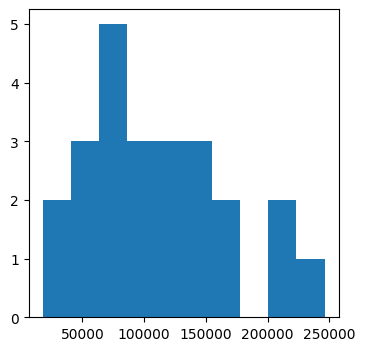

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(data['CoughX'])

(array([6., 5., 2., 5., 2., 3., 0., 0., 0., 1.]),
 array([ 52188.43 ,  61294.905,  70401.38 ,  79507.855,  88614.33 ,
         97720.805, 106827.28 , 115933.755, 125040.23 , 134146.705,
        143253.18 ]),
 <BarContainer object of 10 artists>)

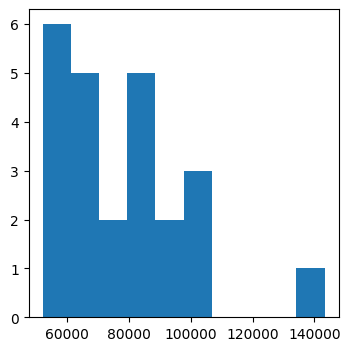

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(data['InfeX'])

In [ ]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data.head(3)

,Date,CoughX,InfeX,year,month
1,2017-01-01,132966.97,66497.86,2017,1
2,2017-02-01,114928.62,52188.43,2017,2
3,2017-03-01,104504.07,68276.89,2017,3


In [ ]:
data['month_count'] = 1
data['month_count'] = data['month_count'].cumsum()

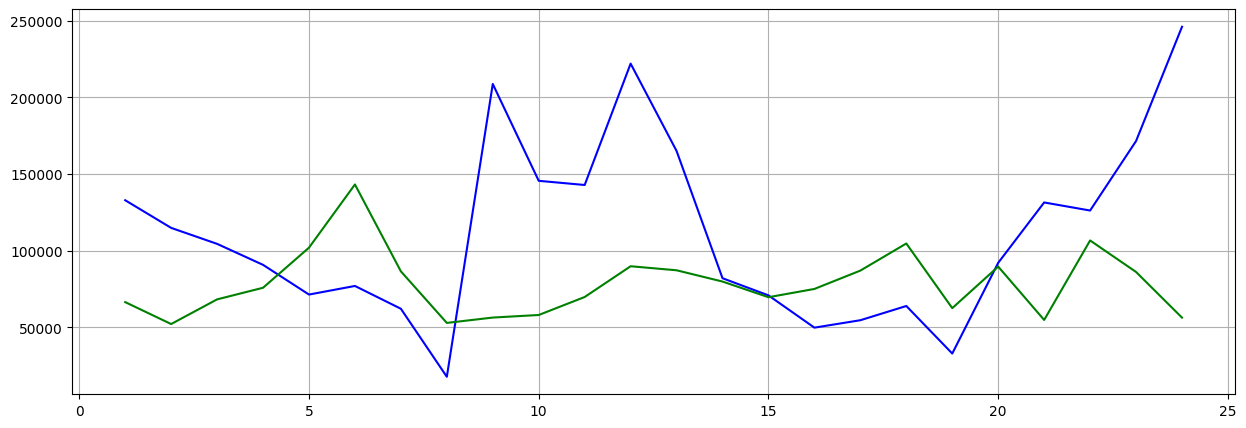

In [ ]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(data['month_count'], data['CoughX'], color='blue')
plt.plot(data['month_count'], data['InfeX'], color='green')

### Product 1

In [ ]:
p1 = data[['year', 'month', 'month_count', 'CoughX']].dropna()
p1 = p1.rename(columns={'CoughX': 'demand'})

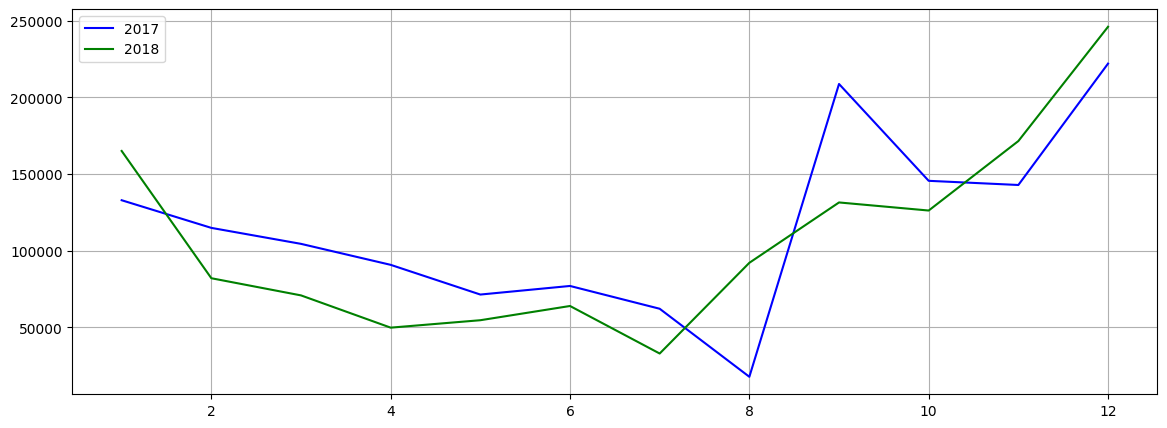

In [ ]:
plt.figure(figsize=(14,5))
plt.grid()
plt.plot(p1[p1['year']==2017]['month'], p1[p1['year']==2017]['demand'], color='blue', label='2017')
plt.plot(p1[p1['year']==2018]['month'], p1[p1['year']==2018]['demand'], color='green', label='2018')
plt.legend()

From the plots of 2018 and 2019 data, we can see that there is some level of seasonality in the demand. We can quantify this by finding the time series decomposition.

In [ ]:
additive_decomp = seasonal_decompose(p1['demand'].dropna(), model='additive', period=12)
multiplicative_decomp = seasonal_decompose(p1['demand'].dropna(), model='multiplicative', period=12)

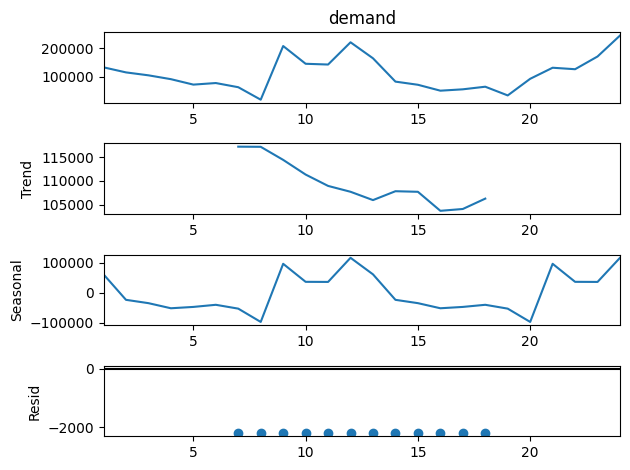

In [ ]:
_ = additive_decomp.plot()

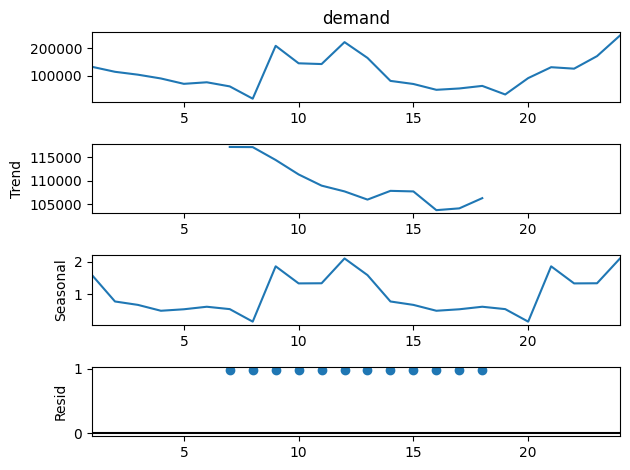

In [ ]:
_ = multiplicative_decomp.plot()

Since the multiplicative decompisition explains the time series better (it has residuls in a smaller scale), we can move forward using that.

In [ ]:
def get_exponential_smoothing_accuracy(df):
    df_train = df['demand'].head(20)
    df_test = df['demand'].tail(4)

    plt.figure(figsize=(13,5))
    plt.plot(df_train, label='train demand')
    plt.plot(df_test, label='actual demand')

    df_pred = pd.DataFrame()
    pred_mse = {}
    pred_mape = {}
    for n_periods in range(2,11):
        model = ExponentialSmoothing(df_train, trend='add', seasonal='mul', seasonal_periods=n_periods).fit()
        df_pred[f'n_periods = {n_periods}'] = model.forecast(4)
        pred_mse[n_periods] = np.sqrt(mean_squared_error(df_test, df_pred[f'n_periods = {n_periods}']))
        pred_mape[n_periods] = np.round(np.mean(np.abs(df_test - df_pred[f'n_periods = {n_periods}']) / df_test) * 100, 2)

    pred_mse = pd.DataFrame(pred_mse.items(), columns=['n_periods', 'mse'])
    pred_mape = pd.DataFrame(pred_mape.items(), columns=['n_periods', 'mape'])

    best_n_periods = pred_mape[pred_mape['mape'] == pred_mape['mape'].min()]['n_periods'].values[0]
    print(best_n_periods, pred_mape['mape'].min())
    plt.plot(df_pred[f'n_periods = {best_n_periods}'],
             label=f'predicted demand n_periods = {best_n_periods}, mape = {pred_mape["mape"].min()}')
    plt.legend()
    plt.show()

    plt.figure()
    plt.figure(figsize=(5,3))
    res = (df_test - df_pred[f'n_periods = {best_n_periods}'])
    plt.scatter(res.index, res, label='residuals')
    plt.legend()
    plt.show()

    n_periods = 12
    model = ExponentialSmoothing(df['demand'], trend='add', seasonal='mul', seasonal_periods=n_periods).fit()
    final_predictions = model.forecast(13)

    return df_pred, final_predictions


3 11.95


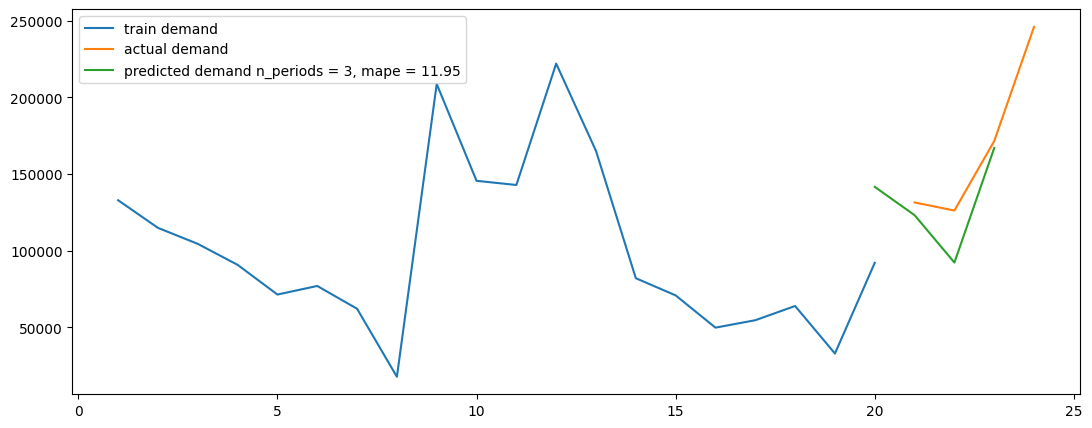

<Figure size 640x480 with 0 Axes>

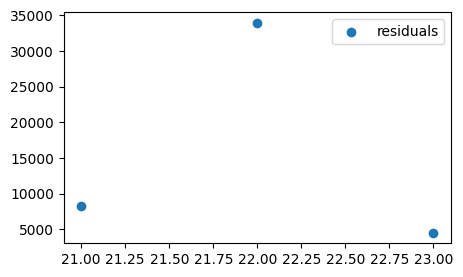

In [ ]:
df_pred, df_pred_exp_smoothing = get_exponential_smoothing_accuracy(p1)

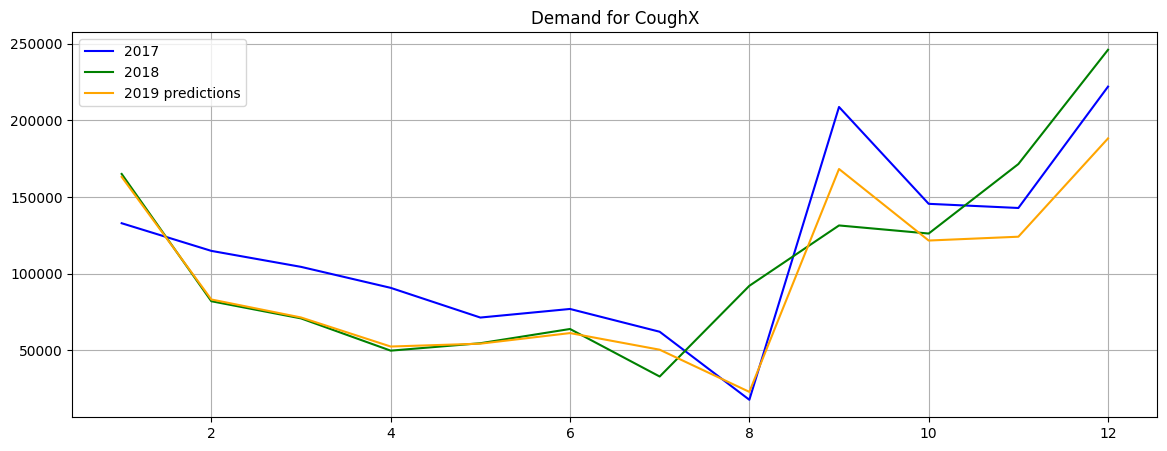

In [ ]:
plt.figure(figsize=(14,5))
plt.grid()
plt.title('Demand for CoughX')
plt.plot(p1[p1['year']==2017]['month'], p1[p1['year']==2017]['demand'], color='blue', label='2017')
plt.plot(p1[p1['year']==2018]['month'], p1[p1['year']==2018]['demand'], color='green', label='2018')
plt.plot(p1[p1['year']==2018]['month'], df_pred_exp_smoothing[:-1], color='orange', label='2019 predictions')
plt.legend()

In [ ]:
p1_2019 = data[data['year']==2019][['year', 'month', 'month_count']]
p1_2019['demand'] = df_pred_exp_smoothing
p1_2019

,year,month,month_count,demand
25,2019,1,25,83226.469846
26,2019,2,26,71482.576790
27,2019,3,27,52523.618235
28,2019,4,28,54392.155802
29,2019,5,29,61296.398305
30,2019,6,30,50447.798457
31,2019,7,31,22934.860755
32,2019,8,32,168360.369771
33,2019,9,33,121678.582521
34,2019,10,34,124172.285975


In [ ]:
p1_2019.to_csv('p1_2019.csv', index=False)

In [ ]:
def get_linear_regression_analysis(df):
    df_2019 = data[data['year']==2019][['year', 'month', 'month_count']]
    df_full = pd.concat([df, df_2019])

    for i in range(1,13):
        df_full[f'lag_{i}'] = df_full['demand'].shift(i)

    cols = [f'lag_{i}' for i in range(1,13)]
    df = df_full[df_full['year'] < 2019].dropna(subset=cols)
    correlations = df[['demand'] + cols].corr()['demand']
    required_features = correlations.loc[lambda x : abs(x) >= 0.3]
    print('Features with correlation > 0.5 (abs):')
    print(required_features, '\n')
    required_features = set(required_features.index) - {'demand'}

    len_train = int(0.8 * len(df))
    len_test = len(df) - len_train
    x = df[required_features]
    y = df['demand']
    x_train = x.head(len_train)
    y_train = y.head(len_train)
    x_test = x.tail(len_test)
    y_test = y.tail(len_test)

    lin_reg = sm.OLS(y_train, x_train).fit()
    y_train_pred = lin_reg.predict(x_train)
    print(lin_reg.summary())

    plt.figure(figsize=(5,3))
    plt.scatter(y_train.index, y_train, label='actual train')
    plt.plot(y_train.index, y_train_pred, 'r', label='lin reg')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5,3))
    res = (y_train - y_train_pred)
    plt.scatter(y_train.index, res, label='residuals')
    plt.legend()
    plt.show()

    y_test_pred = lin_reg.predict(x_test)
    r_squared = r2_score(y_test, y_test_pred)
    print('test r2 score: ', r_squared)
    mape = np.round(np.mean(np.abs(y_test - y_test_pred) / y_test)*100,2)
    print('mape: ', mape)

    plt.figure()
    plt.scatter(y_test.index, y_test, label='test actual')
    plt.plot(y_test.index, y_test_pred, 'r', label='test predicted')
    plt.legend()
    plt.show()

    return

Features with correlation > 0.5 (abs):
0
demand    1.000000
lag_1     0.698873
lag_5    -0.684473
lag_6    -0.612522
lag_7    -0.620160
lag_8    -0.339048
lag_11    0.687448
lag_12    0.774262
Name: demand, dtype: float64 

                                 OLS Regression Results                                
Dep. Variable:                 demand   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              36.76
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                      0.0267
Time:                        20:20:47   Log-Likelihood:                         -93.702
No. Observations:                   9   AIC:                                      201.4
Df Residuals:                       2   BIC:                                      202.8
Df Model:                           7                                   

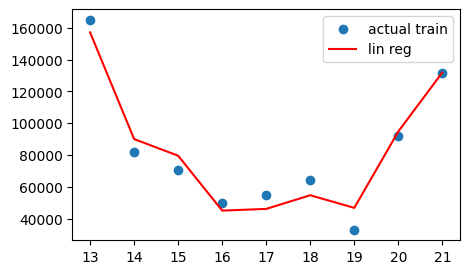

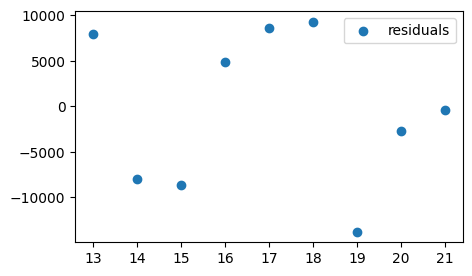

test r2 score:  -0.013642285707495594
mape:  16.45


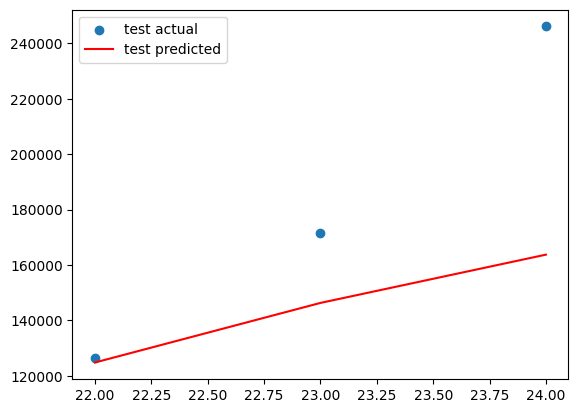

In [ ]:
get_linear_regression_analysis(p1)

### Product 2

In [ ]:
p2 = data[['year', 'month', 'month_count', 'InfeX']].dropna()
p2 = p2.rename(columns={'InfeX': 'demand'})

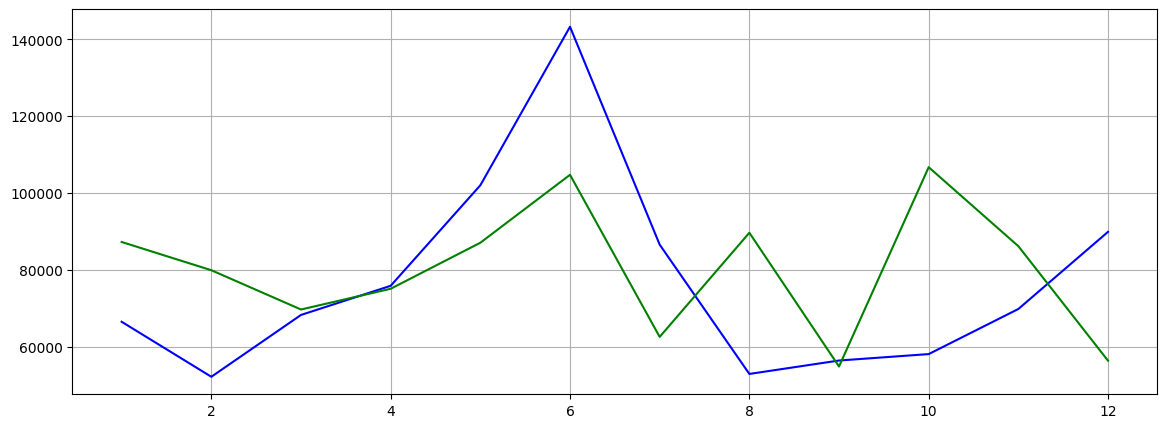

In [ ]:
plt.figure(figsize=(14,5))
plt.grid()
plt.plot(p2[p2['year']==2017]['month'], p2[p2['year']==2017]['demand'], color='blue')
plt.plot(p2[p2['year']==2018]['month'], p2[p2['year']==2018]['demand'], color='green')


In [ ]:
additive_decomp = seasonal_decompose(p2['demand'].dropna(), model='additive', period=12)
multiplicative_decomp = seasonal_decompose(p2['demand'].dropna(), model='multiplicative', period=12)

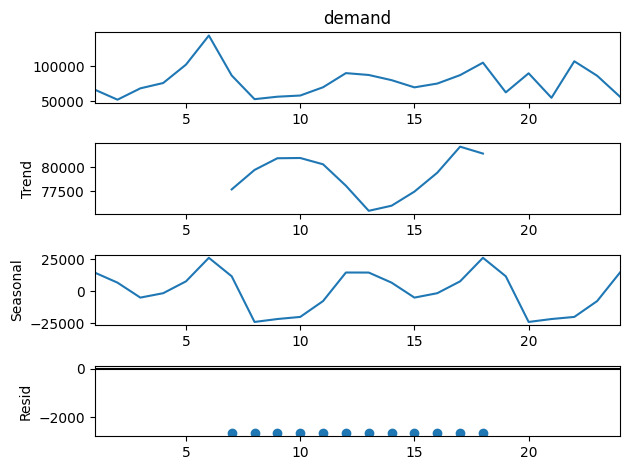

In [ ]:
_ = additive_decomp.plot()

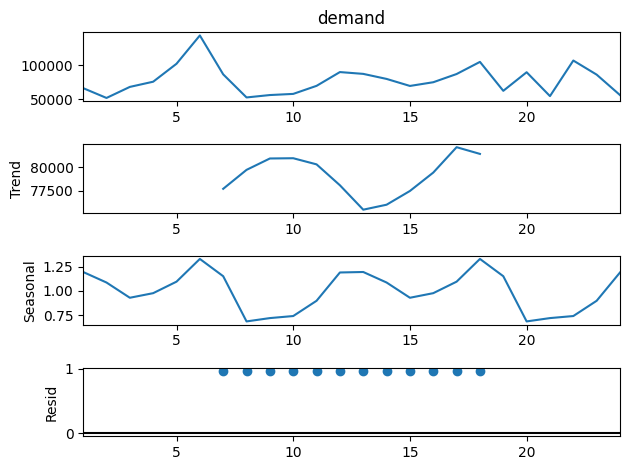

In [ ]:
_ = multiplicative_decomp.plot()

In [ ]:
p2.isna().sum()

0
year           0
month          0
month_count    0
demand         0
dtype: int64

2 26.09


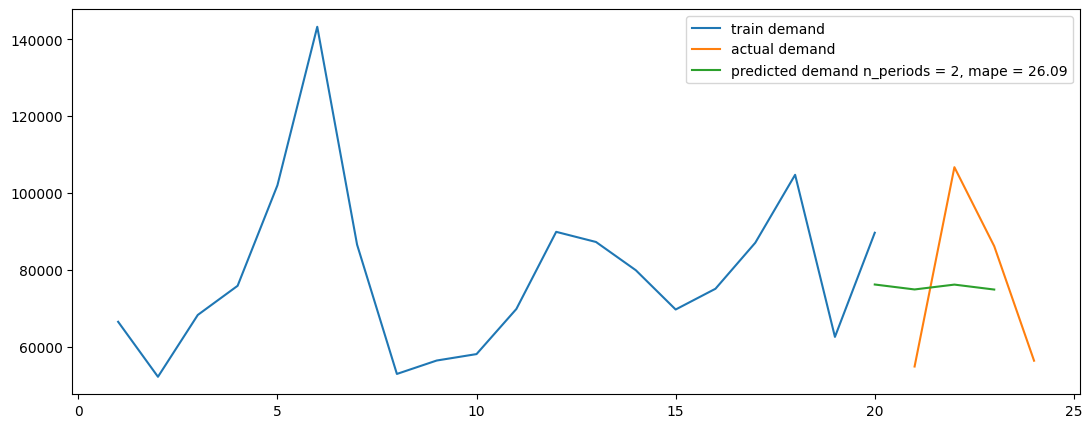

<Figure size 640x480 with 0 Axes>

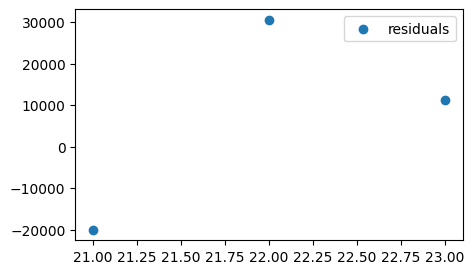

In [ ]:
df_pred, df_pred_exp_smoothing = get_exponential_smoothing_accuracy(p2)

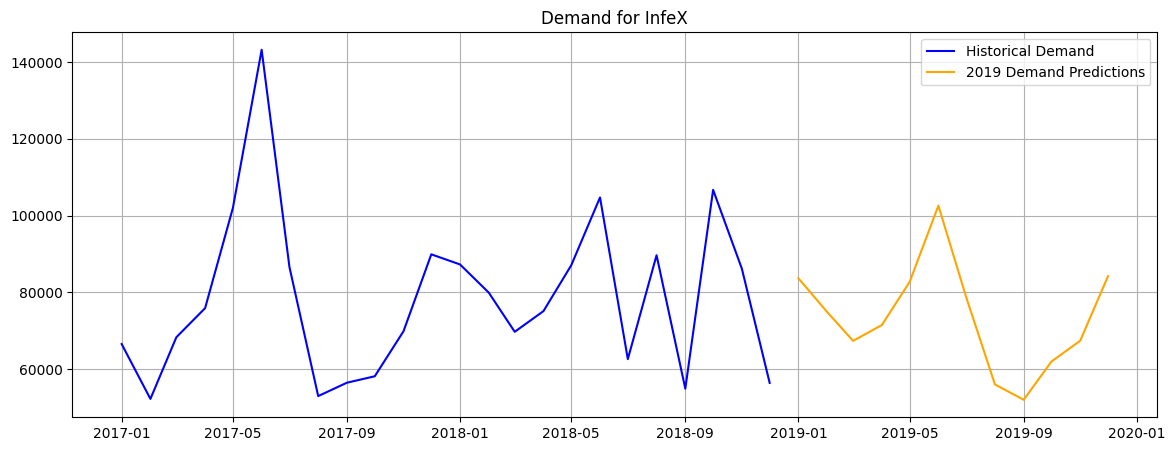

In [ ]:
plt.figure(figsize=(14,5))
plt.grid()
plt.title('Demand for InfeX')
plt.plot(data[data['year']<2019]['Date'], p2[p2['year']<2019]['demand'], color='blue', label='Historical Demand')
#plt.plot(p2[p2['year']==2018]['month'], p2[p2['year']==2018]['demand'], color='green', label='2018')
plt.plot(data[data['year']==2019]['Date'], df_pred_exp_smoothing[:12], color='orange', label='2019 Demand Predictions')
plt.legend()

In [ ]:
df_pred_exp_smoothing.to_csv('p2.csv')

Features with correlation > 0.5 (abs):
0
demand    1.000000
lag_1    -0.425966
lag_5     0.375008
Name: demand, dtype: float64 

                                 OLS Regression Results                                
Dep. Variable:                 demand   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              71.07
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                    2.24e-05
Time:                        20:23:10   Log-Likelihood:                         -100.64
No. Observations:                   9   AIC:                                      205.3
Df Residuals:                       7   BIC:                                      205.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                          

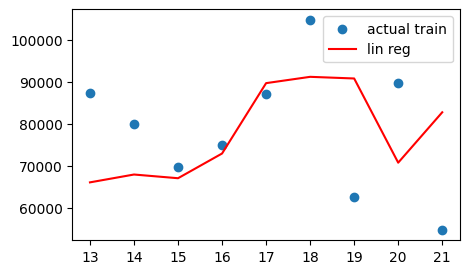

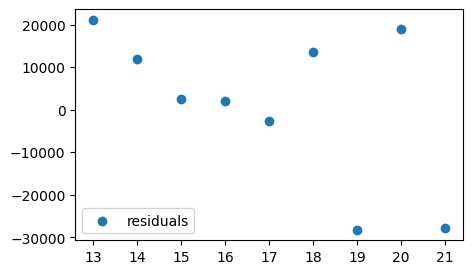

test r2 score:  -0.13519159814725512
mape:  26.51


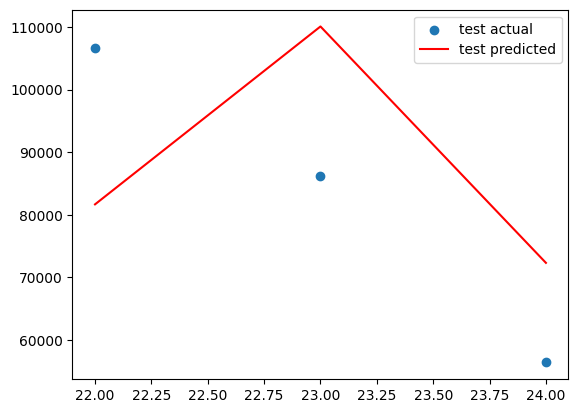

In [ ]:
get_linear_regression_analysis(p2)